# Red del mundo deportivo
## Red de atletas y sus equipos

Los nodos representan a atletas individuales y a equipos individuales.

Los enlaces conecta a un atleta con un equipo del que era miembro.

Para la obtención de los datos utilizaremos la paqueteria de pandas para leer un achivo CSV.

Los datos se obtuvieron de: https://networkrepository.com/ia-dbpedia-team-bi.php

In [ ]:
#Primeramente cargamos las librerias principales
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tqdm
import random

In [ ]:
#cargamos archivo
from google.colab import files
upload = files.upload()

Saving ia-dbpedia-team-bi.edges to ia-dbpedia-team-bi.edges


In [ ]:
# Usa el nombre del archivo subido directamente
ruta = "ia-dbpedia-team-bi.edges"


In [ ]:
# Carga la red
G = nx.from_pandas_edgelist(
    pd.read_csv(ruta,
                skiprows=1,
                header=None,
                sep = ' ',
                usecols= [0, 1]),
    source=0, target=1)



## Propiedades de la red
### Propiedades generales de la red

In [ ]:
# Calcula el grado de cada nodo
grado_dict = dict(nx.degree(G))
Degree = np.array([grado_dict[nodo] for nodo in G])

# Guarda los grados en degree.txt
np.savetxt('degree.txt', Degree)

In [ ]:
Degree = np.loadtxt('degree.txt').astype(int)

In [ ]:
Degree

array([1763, 1813,   17, ...,    1,    1,    1])

In [ ]:
len(Degree)

365492

In [ ]:
N = len(G)
N


365492

In [ ]:
L = len(G.edges)
L

780134

In [ ]:
k=2*L/N # grado promedio
k

4.268952535212809

In [ ]:
nx.average_clustering(G)

0.0009701597142105358

Para la obtención del diametro de la red utilizaremos una muestra de los nodos de la red por tener un tamaño tan grande


In [ ]:
muestra = random.sample(list(G.nodes()), 1000)

In [ ]:
# Muestra un subconjunto de nodos para estimar el diámetro
maxima_distancia_encontrada = 0

for source_node in tqdm.tqdm(muestra):
    # nx.shortest_path_length devuelve un diccionario de {destino: distancia}
    distancias = nx.shortest_path_length(G, source=source_node)

    # El valor más grande en este diccionario es la distancia máxima desde este origen
    max_dist_desde_origen = max(distancias.values())

    # Actualizar la distancia más grande encontrada hasta ahora (estimación del diámetro)
    if max_dist_desde_origen > maxima_distancia_encontrada:
        maxima_distancia_encontrada = max_dist_desde_origen

print(f"La estimación del Diámetro es (valor): {maxima_distancia_encontrada}")

100%|██████████| 1000/1000 [10:24<00:00,  1.60it/s]

La estimación del Diámetro es (valor): 10


### Gráfica de medidas de centralidad


Para ver las medidas de centralidad utilizares una función que nos de una muestra representativa de la red

In [ ]:
def muestra_representativa(G, tamano_deseado):
    random.seed(42)
    nodo_inicial = random.choice(list(G.nodes()))
    visitados = {nodo_inicial}
    frontera = [nodo_inicial]

    while len(visitados) < tamano_deseado and frontera:
        actual = frontera.pop(0)
        for vecino in G.neighbors(actual):
            if vecino not in visitados:
                visitados.add(vecino)
                frontera.append(vecino)
                if len(visitados) >= tamano_deseado:
                    break
    return G.subgraph(visitados).copy()


In [ ]:
G_rep = muestra_representativa(G, 5000)

Obtendremos varios centralidades de la red y las graficaremos en un mapa de calor con la idea de ver que centralidades son adecuadas

In [ ]:
atributo1 = nx.betweenness_centrality(G_rep)

In [ ]:
atributo2 = nx.closeness_centrality(G_rep)

In [ ]:
atributo3 = nx.eigenvector_centrality(G_rep, max_iter=1000, tol=1e-06)

In [ ]:
atributo5 = nx.katz_centrality(G_rep, max_iter=5000, alpha=0.001, tol=1e-06)

In [ ]:
cuatro_centralidades = [atributo1, atributo2, atributo3, atributo5]
df_central = pd.DataFrame(cuatro_centralidades).T
df_central.columns = [ 'Betweness','Closeness','Eigenvector', 'Katz']
df_central

,Betweness,Closeness,Eigenvector,Katz
6,0.005246,0.311775,0.050336,0.014811
9,0.002105,0.272990,0.008217,0.014331
14,0.006848,0.285298,0.044852,0.015027
15,0.001660,0.268995,0.035530,0.014741
16,0.000010,0.255586,0.003327,0.014102
...,...,...,...,...
327602,0.000009,0.264721,0.014039,0.014096
163764,0.000126,0.314977,0.021772,0.014140
65461,0.000000,0.239634,0.000666,0.014074
360406,0.000000,0.222099,0.000048,0.014073


In [ ]:
df_central.corr()

,Betweness,Closeness,Eigenvector,Katz
Betweness,1.000000,0.164476,0.568593,0.795433
Closeness,0.164476,1.000000,0.616767,0.276845
Eigenvector,0.568593,0.616767,1.000000,0.695449
Katz,0.795433,0.276845,0.695449,1.000000


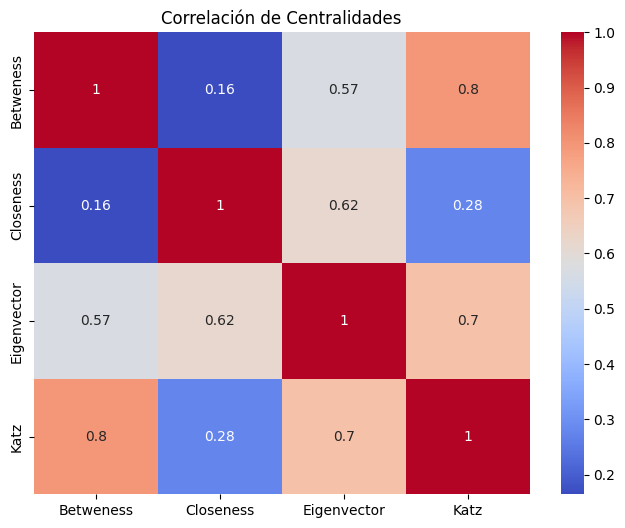

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(df_central.corr(), annot=True, cmap='coolwarm')
plt.title('Correlación de Centralidades')
plt.show()

Dado el mapa de calor, consideramos que la centralidad de Betweennes y de egenvector es adecuado para el gráfico

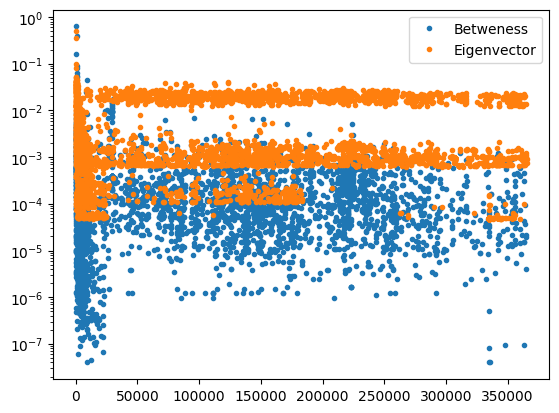

In [ ]:
df_central[[ 'Betweness','Eigenvector']].plot(lw = 0, marker = '.')
plt.yscale('log')

### Visualización de un subconjunto de la red


Para la visuablización de la red volveremos a utilizar la función que nos da una muestra representativa pero ahora sera de la red previamente ya obtenida, es decir, de G_rep.

Después procedemos a definir la función Atributo para visualizarlos en la imagén

In [ ]:
#función que no lo pone en forma de arrglo el diccionario
def Atributo(centralidad, G):
    diccionario = nx.degree_centrality(G) #nos regresa valores entre 0 y 1 de cada nodo que estan normalizados
    atributo = np.array([diccionario[nodo] for nodo in G])
    return atributo


In [ ]:
G_vis = muestra_representativa(G_rep,1000)

In [ ]:
atributo1 = nx.betweenness_centrality(G_vis)

In [ ]:
atributo3 = nx.eigenvector_centrality(G_vis, max_iter=1000, tol=1e-06)

In [ ]:
pos1 = nx.spring_layout(G_vis)

In [ ]:
pos3 = nx.kamada_kawai_layout(G_vis)

Probamos dos tipos de layaut, sin embargo, vemos que kamada_kawai nos da la mejor vidsualización por exponer claramete los nodos superiores

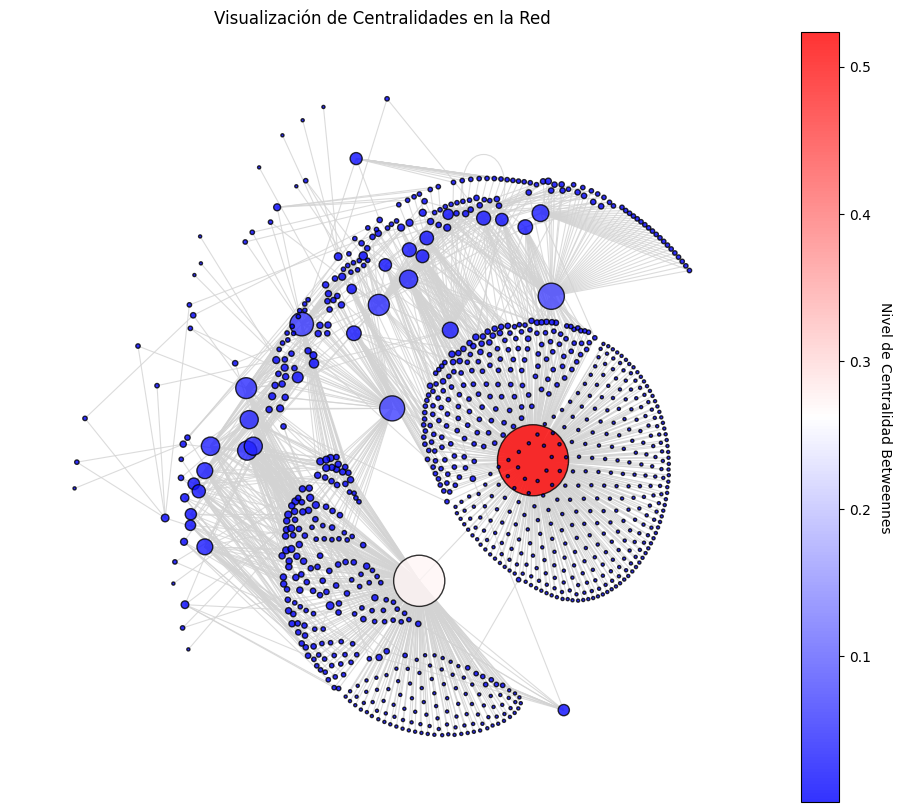

In [ ]:
plt.figure(figsize=(12, 10))

# Diseñamos nodos
nodos = nx.draw_networkx_nodes(
    G_vis,
    pos = pos3,
    node_size = Atributo(atributo3,G_vis) * 5000,
    node_color = Atributo(atributo1, G_vis),
    cmap = 'bwr',           # Tu mapa de color
    edgecolors = 'Black',  # El borde de los nodos
    alpha = 0.8
)


nx.draw_networkx_edges(
    G_vis,
    pos = pos3,
    edge_color = 'lightgray',
    width = 0.8,
    alpha = 0.8
)

cbar = plt.colorbar(nodos) #mostrmos la barra de calor
cbar.set_label('Nivel de Centralidad Betweennes', rotation=270, labelpad=15)

plt.title("Visualización de Centralidades en la Red")
plt.axis('off') # Quita los ejes
plt.show()

### Distribución de grado


Grficaremos el grado de la red utilizando el archivo txt ya fabricado

In [ ]:
max_deg = Degree.max()
y0,x0 = np.histogram(Degree, bins = range(max_deg+2))

Text(0, 0.5, 'Frecuencia')

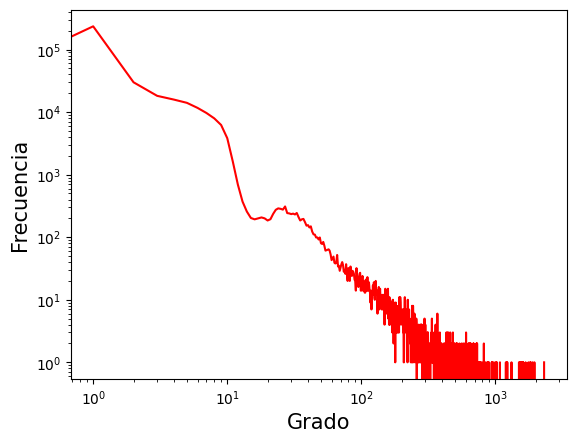

In [ ]:
plt.plot(x0[:-1], y0, color = 'red')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Grado', size = 15)
plt.ylabel('Frecuencia', size = 15)


### Interpretación

La red presenta una topología de libre escala (Scale-Free), evidenciada por una distribución de grados que sigue una ley de potencia con pendiente negativa; esto indica la existencia de  pocos "elites" (equipos o atletas dominantes) que sostienen la conectividad frente a una gran mayoría de nodos con baja vinculación. El grado promedio de 4.3 sugiere una red dispersa, donde la arquitectura se mantiene integrada gracias a estos nodos centrales. Por otro lado, el bajísimo coeficiente de clustering (0.001) confirma que la red es puramente funcional y carece de comunidades agrupadas; en términos deportivos, esto significa que los atletas no suelen formar grupos exclusivos que se mueven juntos, sino que se mueven individualmente entre equipos como se esperaria en la vida real y se confirma en ella.

Finalmente, la buena correlación entre Betweenness y Eigenvector muestra que los nodos más influyentes son también los puentes principales del sistema. Mientras que los nodos grandes y rojos actúan como conectores globales, los nodos medianos y azules representan autoridades locales con gran relevancia dentro de su entorno, pero con poca participación en la comunicación o enlace entre clústeres distantes.

## Comparación con modelos
### Modelo de red aleatoria G(N,p)


In [ ]:
from scipy.stats import poisson

In [ ]:
max_deg = Degree.max()
y0,x0 = np.histogram(Degree, bins = range(max_deg+2), density = True)

In [ ]:
k

4.268952535212809

In [ ]:
p = k / (N-1)
p

1.1680048305465275e-05

Text(0.5, 0, 'k')

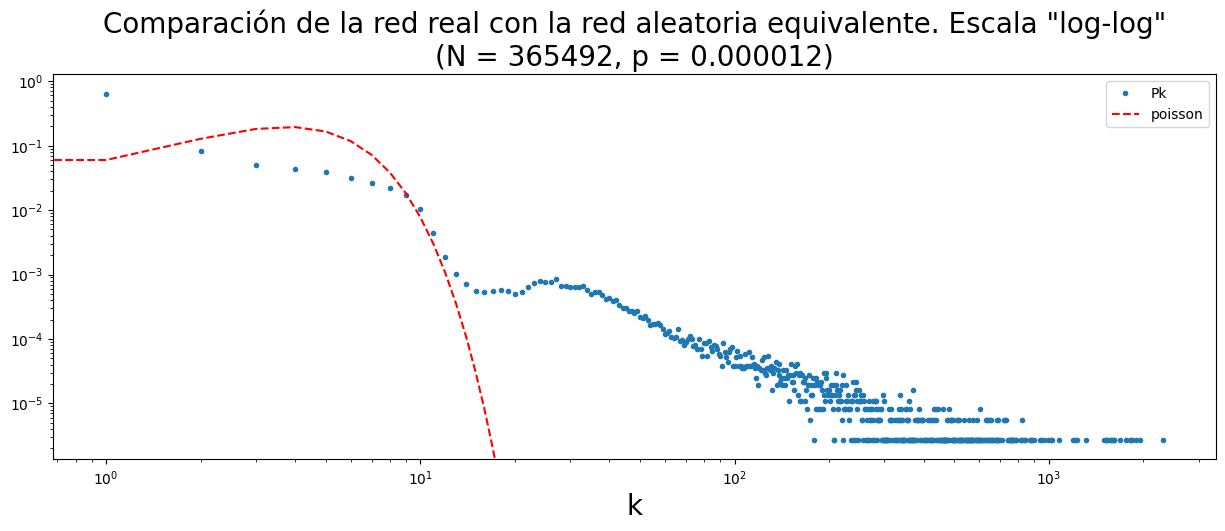

In [ ]:
plt.figure(figsize = [15,5])
plt.plot(x0[:-1], y0, '.', label = 'Pk')
plt.plot(x0[:-1], poisson.pmf(x0[:-1], k), 'r--', label = 'poisson')

#Se aplica escala logarítmica a ambos ejes
plt.xscale('log')
plt.yscale('log')

#parámetros adecuados para la visualización:
plt.ylim([0.5*y0[y0>0].min(),2*y0.max()])
plt.legend()

plt.title('Comparación de la red real con la red aleatoria equivalente. Escala "log-log"\n(N = %i, p = %.6f)' %(N,p), size = 20)
plt.xlabel('k', size = 20)

Vemos que definitivamente la red no sigue un modelo aleatorio pues se ve la predominancia de los nodos con alto grado mostrando mas bien una ley de potencias y una una distribución uniforme dictada por la aleatoria

### Red con independencia de escala


Veamos la distribución del grado

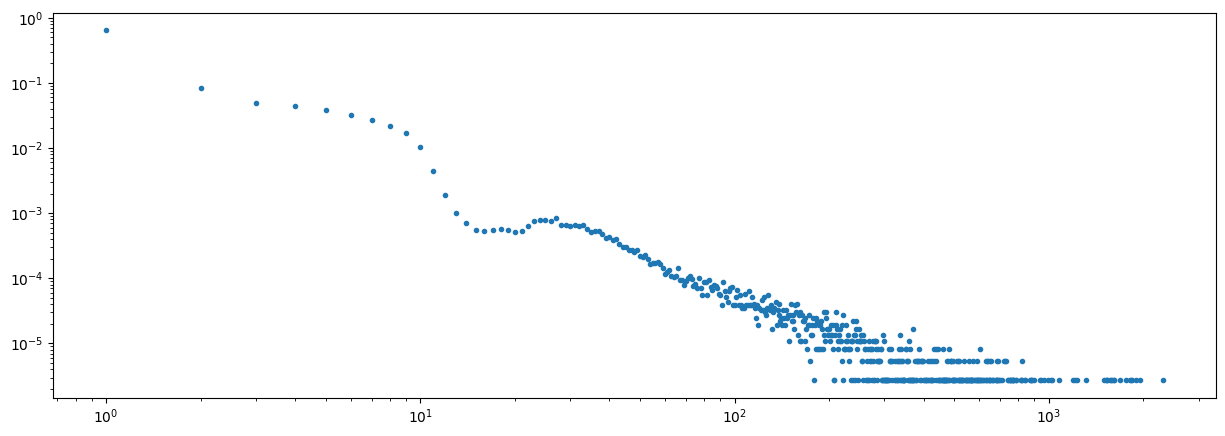

In [ ]:
K = Degree.max()
y0, x0 = np.histogram(Degree,
                      bins = range(int(K) + 2),
                      density = True)

plt.figure(figsize = [15,5])
plt.plot(x0[:-1], y0, '.')
plt.xscale('log')
plt.yscale('log')


Vemos que sigue la tendencia de la ley de potencias

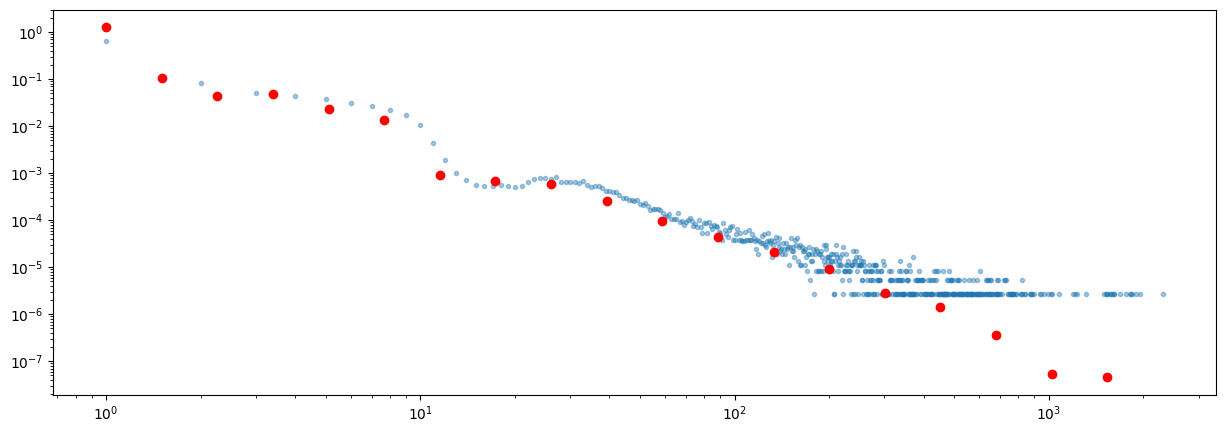

In [ ]:
log_bins = np.logspace(0, np.log10(K+2), 20)

y, x = np.histogram(Degree,
                    bins = log_bins,
                    density = True,
                    )

plt.figure(figsize = [15,5])
plt.plot(x0[:-1], y0, '.', alpha = .4)

plt.plot(x[:-1], y, 'ro')

plt.xscale('log')
plt.yscale('log')

Procedemos a calcular el exponente alfa de la red

In [ ]:
!pip install powerlaw
import powerlaw

In [ ]:
fit = powerlaw.Fit(Degree)

Calculating best minimal value for power law fit


In [ ]:
fit.alpha

np.float64(2.2318443664956433)

In [ ]:
fit.xmin

np.float64(27.0)

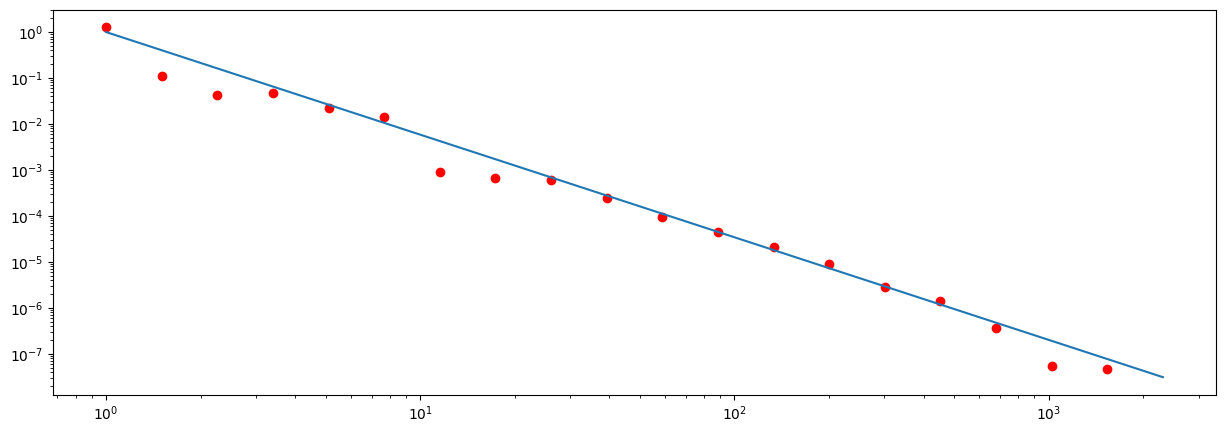

In [ ]:
plt.figure(figsize = [15,5])

plt.plot(x[:-1], y, 'ro')
plt.plot(x, x**(-fit.alpha))

plt.xscale('log')
plt.yscale('log')

De aqui vemos que nos enocntramos en el regimen interesante donde el grado tiene promedio finito y segundo momento infinito pues alfa esta entre 2 y 3

###Conclusiones

La red presenta una distribución de colas gordas, lo que confirma la existencia de nodos determinantes que concentran la mayor cantidad de conexiones en el sistema. Al contrastar con el modelo aleatorio, la diferencia es absoluta: mientras que el modelo de Poisson predice una distribución homogénea y sin grandes centros de conexión, la red real se rige por una jerarquía estructural. En este sistema los enlaces no se dan al azar, sino que siguen una lógica de importancia donde los equipos y jugadores de élite actúan como los conexiones principales que dan la cohesión y la esencia de la red

## Proceso
Dada las condiciones de la red establecemos que el proceso perfeto es de percolación pues podemos ver la susceptibilidad de la red al quitar nodos elites

Definimos primeramente el proceso de percolación

In [ ]:
def percolacion_red(G,f,ataque=False):
    num_nodos_a_remover = int(f * G.number_of_nodes())

    if(ataque):
        nodos = [nodo for nodo,grado in sorted(G.degree(),key=lambda item:item[1],reverse=True)]
        nodos_a_remover = nodos[0:num_nodos_a_remover]
    else:
        random.seed(42)
        nodos = list(G.nodes)
        nodos_a_remover = random.sample(nodos,num_nodos_a_remover)

    G.remove_nodes_from(nodos_a_remover)
    tamanio_max_comp = len(max(nx.connected_components(G),key=len))

    return tamanio_max_comp

procedemos a realizar el proceso en la red

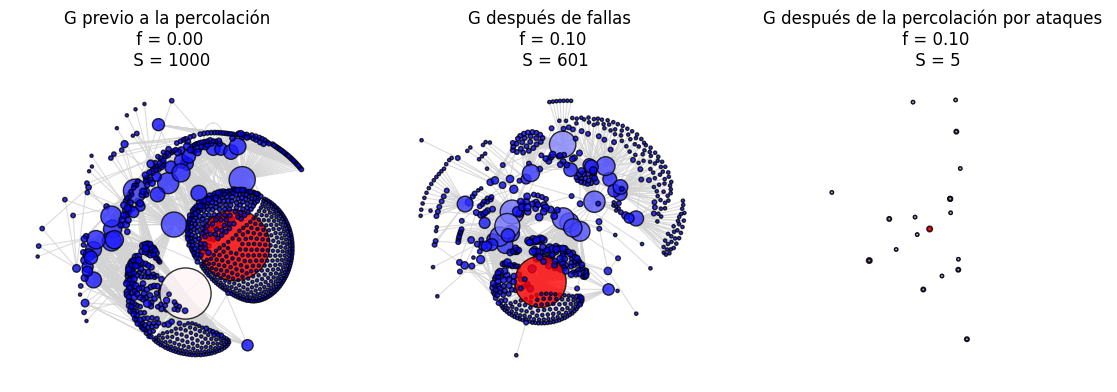

In [ ]:
f = 0.1

G_1 = G_vis.copy()
G_2 = G_vis.copy()
pos = pos3

fig, axs = plt.subplots(1,3,figsize=(14,4))
# se calcula el tamaño de la máxima componente
# y se grafica previo a la percolación (f=0)
tamanio_max_comp = percolacion_red(G_vis,0)

nx.draw(
    G_vis,
    pos = pos3,
    node_size = Atributo(atributo3, G_vis) * 5000,
    node_color = Atributo(atributo1, G_vis),
    cmap = 'bwr',              # Tu mapa de color azul-blanco-rojo
    edgecolors = 'Black',     # El borde de los nodos
    edge_color = 'lightgray',     # CAMBIO: Enlaces en claro
    width = 0.8,               # ancho de enlace
    alpha = 0.8,               # fuerza del color
    with_labels=False,ax=axs[0]
)
axs[0].set_title('G previo a la percolación \n f = %.2f \n S = %i' %(0,tamanio_max_comp))


# se corre la percolación por fallas en esa misma red y se grafica
tamanio_max_comp = percolacion_red(G_1,f)

atributo1 = nx.betweenness_centrality(G_1)
atributo3 = nx.eigenvector_centrality(G_1, max_iter=1000, tol=1e-06)

pos_g1 =  nx.kamada_kawai_layout(G_1)

nx.draw(
    G_1,
    pos = pos_g1, # <--- Usar la posición filtrada
    node_size = Atributo(atributo3, G_1) * 5000,
    node_color = Atributo(atributo1, G_1),
    cmap = 'bwr',
    edgecolors = 'Black',
    edge_color = 'lightgray',
    width = 0.8,
    alpha = 0.8,
    with_labels = False,
    ax = axs[1]
)
axs[1].set_title(f'G después de fallas \n f = {f:.2f} \n S = {tamanio_max_comp}')

# se corre la percolación por ataques en la red
tamanio_max_comp = percolacion_red(G_2,f, ataque = True)

atributo1 = nx.betweenness_centrality(G_2)
atributo3 = nx.eigenvector_centrality(G_2, max_iter=1000, tol=1e-06)

pos_g2 =  nx.kamada_kawai_layout(G_2)

nx.draw(
    G_2,
    pos = pos_g2,
    node_size = Atributo(atributo3, G_2) * 5000,
    node_color = Atributo(atributo1, G_2),
    cmap = 'bwr',
    edgecolors = 'Black',
    edge_color = 'lightgray',
    width = 0.8,
    alpha = 0.8,
    with_labels = False,
    ax = axs[2]
)
axs[2].set_title('G después de la percolación por ataques \n f = %.2f \n S = %i' %(f,tamanio_max_comp))

plt.show()

### Interpretación
Vemos que la red es considerablemente vulnerable a el ataque de los nodos con grado alto pues sin ellos queda básicamente fragmentada. Esto era de esperarse pues vimos que sigue una ley de potencias determinando que unos pocos nodos tienen la mayor conetividad y al quitarlos las conexiones desvanecen

##Conclusión

La red deportiva analizada está gobernada por una élite de equipos y atletas dominantes que actúan como hubs deportivos. La arquitectura de la red depende tanto de ellos que su ausencia fragmentaría el sistema, demostrando que estamos ante una red de libre escala vulnerable a ataques dirigidos. En este ecosistema, se observa claramente el fenómeno de 'conexión preferencial': los nodos más conectados tienden a recibir más enlaces, consolidando su poder global, mientras que los actores locales mantienen relevancia en su entorno pero no logran trascender globalmente.

Este fenómeno tiene un reflejo directo en el mundo real. Equipos de élite como el Real Madrid intercambian constantemente nodos (jugadores) de alta jerarquía con clubes de su mismo nivel, como la Juventus o el Chelsea, creando un núcleo denso y exclusivo. Sin embargo, cuando una 'estrella' de este núcleo migra a ligas de menor jerarquía —como el caso de Sergio Ramos hacia el fútbol mexicano—, actúa como un puente vital (alto Betweenness) que conecta mercados que de otro modo estarían aislados. Por el contrario, equipos con un rol local fuerte, como el Cruz Azul de  la liga Méxicana, generan un gran flujo de conexiones dentro de su región o jerarquía, pero su impacto no alcanza la profundidad o amplitud de los nodos globales, evidenciando una jerarquía deportiva definida.